# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

<ipython-input-1-1499ab5789c7>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler
from pytorch_model import Conditional_VAE as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
log_file = config['IO_OPTION']['OUTPUT_ROOT']+'/train_{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_file, '00_train.py')

## Setting

In [5]:
# Setting seed
modeler.set_seed(777)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
#dev_dir = INPUT_ROOT + "/dev_data"
#add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = ['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
OUT_SCORE_DIR = OUTPUT_ROOT + '/score'
OUT_PRED_DIR = OUTPUT_ROOT + '/pred'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
os.makedirs(OUT_SCORE_DIR, exist_ok=True)
os.makedirs(OUT_PRED_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/CenterLossVAE/ex5/config.yaml'

In [7]:
torch.cuda.is_available()

True

In [8]:
ext_data = pd.read_pickle(f'{INPUT_ROOT}/valve_features.pkl')

In [9]:
pd.DataFrame(ext_data['train']['features'])

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,0.141376,0.126192,0.160170,0.039393,0.116594,0.244344,0.364260,0.179045,0.304383,0.316418,...,0.000000,0.000000,0.000000,0.0,0.011685,0.0,0.0,0.0,0.001349,0.024873
1,0.139377,0.119569,0.153211,0.039412,0.117448,0.268657,0.362977,0.172853,0.304429,0.321536,...,0.000558,0.000000,0.000185,0.0,0.019411,0.0,0.0,0.0,0.010698,0.031158
2,0.163800,0.184355,0.172159,0.027273,0.110422,0.169510,0.386510,0.206604,0.313434,0.314130,...,0.011560,0.000000,0.000000,0.0,0.038945,0.0,0.0,0.0,0.000000,0.005341
3,0.143226,0.131679,0.156749,0.038878,0.115537,0.241695,0.368068,0.185738,0.308175,0.316420,...,0.000000,0.000457,0.000000,0.0,0.005694,0.0,0.0,0.0,0.008102,0.020985
4,0.137737,0.123774,0.149359,0.042918,0.111843,0.259588,0.368717,0.180469,0.305680,0.309504,...,0.000000,0.000000,0.000000,0.0,0.018220,0.0,0.0,0.0,0.003810,0.032367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6013,0.116490,0.110039,0.161647,0.043416,0.096190,0.239978,0.371168,0.168759,0.329152,0.293912,...,0.000000,0.000000,0.000000,0.0,0.002287,0.0,0.0,0.0,0.000226,0.023715
6014,0.125852,0.120752,0.164564,0.039160,0.104617,0.234347,0.369856,0.180599,0.320280,0.302117,...,0.001283,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.001988,0.014878
6015,0.107534,0.116570,0.173803,0.039604,0.088328,0.213753,0.390930,0.170922,0.355653,0.284926,...,0.000713,0.026625,0.000000,0.0,0.009445,0.0,0.0,0.0,0.005314,0.000665
6016,0.123527,0.140547,0.164611,0.038327,0.096956,0.192954,0.382039,0.200973,0.332633,0.290760,...,0.002548,0.011003,0.000000,0.0,0.011084,0.0,0.0,0.0,0.004229,0.010059


## training

In [10]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dataloader
    ext_data = pd.read_pickle(f'{INPUT_ROOT}/{machine_type}_features.pkl')
    dataloaders_dict = modeler.make_dataloader(ext_data)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    # out path
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    score_out_path = OUT_SCORE_DIR + '/{}_score.csv'.format(machine_type)
    pred_out_path = OUT_PRED_DIR + '/{}_pred.csv'.format(machine_type)
    logger.info('TRAINING')
    # parameter setting
    in_features = ext_data['train']['features'].shape[1]
    mid_size = config['param']['mid_size']
    latent_size = config['param']['latent_size']
    num_classes = 6
    net = Model(in_features, mid_size, latent_size, num_classes)
    optimizer = optim.Adam(net.parameters(), lr=1e-4)
    num_epochs = config['param']['num_epochs']
    #scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e-2, 
    #                                          max_lr=1e-3, epochs=num_epochs, steps_per_epoch=len(dataloaders_dict['train']))
    # training
    output_dicts = modeler.train_net(net, dataloaders_dict, optimizer, num_epochs, writer, model_out_path, score_out_path, pred_out_path)
    
    com.toc()

In [11]:
machine_types

['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']

In [12]:
#for machine_type in machine_types:
#    run(machine_type)

2021-05-24 00:17:11,102 - 00_train.py - INFO - TARGET MACHINE_TYPE: slider
2021-05-24 00:17:11,103 - 00_train.py - INFO - MAKE DATA_LOADER
2021-05-24 00:17:11,631 - 00_train.py - INFO - TRAINING
2021-05-24 00:17:11,846 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 19.24it/s]
2021-05-24 00:17:12,472 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  6.05it/s]
2021-05-24 00:17:12,824 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  6.22it/s]


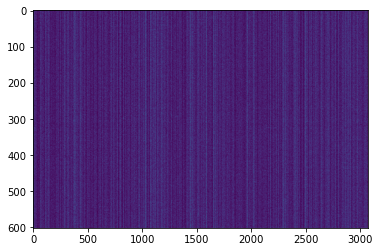

,AUC,pAUC
Source_0,0.425300,0.484737
Source_1,0.401850,0.490000
Source_2,0.484225,0.495731
Target_0,0.473800,0.531579
Target_1,0.467653,0.500215
Target_2,0.526240,0.512030
mean,0.463178,0.502382
h_mean,0.459624,0.501909


2021-05-24 00:17:14,104 - pytorch_modeler.py - INFO - epoch:1/300, train_losses:166.860446, val_AUC_hmean:0.459624, val_pAUC_hmean:0.501909, best_flag:True
2021-05-24 00:17:14,109 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.27it/s]
2021-05-24 00:17:14,651 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.86it/s]
2021-05-24 00:17:14,898 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.53it/s]
2021-05-24 00:17:15,112 - pytorch_modeler.py - INFO - epoch:2/300, train_losses:116.124575, val_AUC_hmean:0.478178, val_pAUC_hmean:0.496613, best_flag:False
2021-05-24 00:17:15,114 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.72it/s]
2021-05-24 00:17:15,602 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.54it/s]
2021-05-24 00:17:15,832 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.39it/s]
2021-05-24 00:17:16

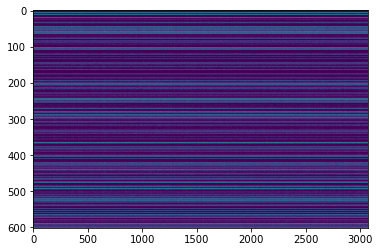

,AUC,pAUC
Source_0,0.419900,0.483684
Source_1,0.529800,0.522632
Source_2,0.646881,0.503706
Target_0,0.600500,0.492632
Target_1,0.525306,0.522879
Target_2,0.608708,0.507780
mean,0.555182,0.505552
h_mean,0.544136,0.505140


2021-05-24 00:17:18,690 - pytorch_modeler.py - INFO - epoch:5/300, train_losses:80.792557, val_AUC_hmean:0.544136, val_pAUC_hmean:0.505140, best_flag:True
2021-05-24 00:17:18,691 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.75it/s]
2021-05-24 00:17:19,159 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.40it/s]
2021-05-24 00:17:19,376 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.10it/s]


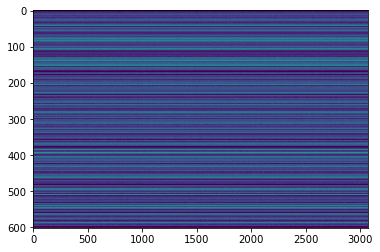

,AUC,pAUC
Source_0,0.417700,0.493684
Source_1,0.532800,0.564737
Source_2,0.703387,0.557651
Target_0,0.599400,0.495789
Target_1,0.498163,0.514286
Target_2,0.636486,0.564641
mean,0.564656,0.531798
h_mean,0.548473,0.529941


2021-05-24 00:17:20,420 - pytorch_modeler.py - INFO - epoch:6/300, train_losses:75.158213, val_AUC_hmean:0.548473, val_pAUC_hmean:0.529941, best_flag:True
2021-05-24 00:17:20,421 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.43it/s]
2021-05-24 00:17:20,895 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.89it/s]
2021-05-24 00:17:21,119 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.57it/s]


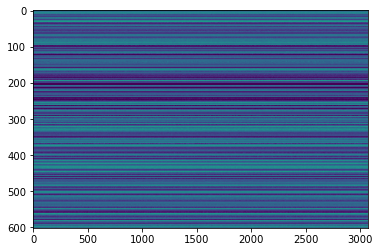

,AUC,pAUC
Source_0,0.397700,0.496842
Source_1,0.653700,0.571579
Source_2,0.722906,0.559527
Target_0,0.603600,0.488421
Target_1,0.514898,0.518582
Target_2,0.642445,0.577086
mean,0.589208,0.535340
h_mean,0.566951,0.532951


2021-05-24 00:17:22,161 - pytorch_modeler.py - INFO - epoch:7/300, train_losses:70.521004, val_AUC_hmean:0.566951, val_pAUC_hmean:0.532951, best_flag:True
2021-05-24 00:17:22,162 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.47it/s]
2021-05-24 00:17:22,618 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.49it/s]
2021-05-24 00:17:22,832 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.34it/s]


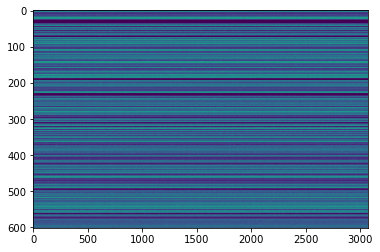

,AUC,pAUC
Source_0,0.401800,0.488947
Source_1,0.718000,0.565263
Source_2,0.722816,0.557182
Target_0,0.571800,0.496316
Target_1,0.586633,0.526423
Target_2,0.637255,0.584269
mean,0.606384,0.536400
h_mean,0.583217,0.534043


2021-05-24 00:17:23,939 - pytorch_modeler.py - INFO - epoch:8/300, train_losses:66.995879, val_AUC_hmean:0.583217, val_pAUC_hmean:0.534043, best_flag:True
2021-05-24 00:17:23,940 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.99it/s]
2021-05-24 00:17:24,405 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.41it/s]
2021-05-24 00:17:24,621 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.38it/s]
2021-05-24 00:17:24,858 - pytorch_modeler.py - INFO - epoch:9/300, train_losses:64.313135, val_AUC_hmean:0.624826, val_pAUC_hmean:0.530871, best_flag:False
2021-05-24 00:17:24,859 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.89it/s]
2021-05-24 00:17:25,325 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.33it/s]
2021-05-24 00:17:25,543 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.09it/s]


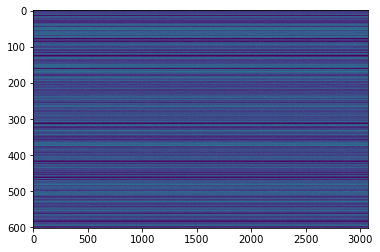

,AUC,pAUC
Source_0,0.547800,0.500000
Source_1,0.809600,0.581053
Source_2,0.738681,0.559996
Target_0,0.532800,0.498947
Target_1,0.620714,0.540172
Target_2,0.622837,0.569902
mean,0.645405,0.541678
h_mean,0.631054,0.539718


2021-05-24 00:17:26,593 - pytorch_modeler.py - INFO - epoch:10/300, train_losses:61.999379, val_AUC_hmean:0.631054, val_pAUC_hmean:0.539718, best_flag:True
2021-05-24 00:17:26,594 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.22it/s]
2021-05-24 00:17:27,054 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  8.98it/s]
2021-05-24 00:17:27,300 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.58it/s]
2021-05-24 00:17:27,534 - pytorch_modeler.py - INFO - epoch:11/300, train_losses:60.419307, val_AUC_hmean:0.631541, val_pAUC_hmean:0.528662, best_flag:False
2021-05-24 00:17:27,535 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.17it/s]
2021-05-24 00:17:28,014 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.37it/s]
2021-05-24 00:17:28,231 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.72it/s]


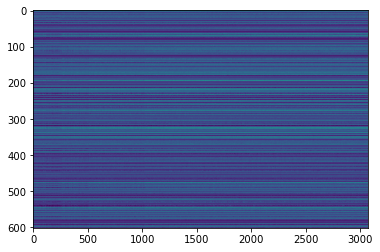

,AUC,pAUC
Source_0,0.598500,0.517368
Source_1,0.801500,0.557895
Source_2,0.741087,0.574538
Target_0,0.531600,0.513158
Target_1,0.601327,0.534372
Target_2,0.633891,0.550375
mean,0.651317,0.541284
h_mean,0.639009,0.540401


2021-05-24 00:17:29,308 - pytorch_modeler.py - INFO - epoch:12/300, train_losses:59.085866, val_AUC_hmean:0.639009, val_pAUC_hmean:0.540401, best_flag:True
2021-05-24 00:17:29,309 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.65it/s]
2021-05-24 00:17:29,779 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.32it/s]
2021-05-24 00:17:29,995 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.34it/s]
2021-05-24 00:17:30,232 - pytorch_modeler.py - INFO - epoch:13/300, train_losses:57.959969, val_AUC_hmean:0.637615, val_pAUC_hmean:0.536668, best_flag:False
2021-05-24 00:17:30,234 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.51it/s]
2021-05-24 00:17:30,706 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.18it/s]
2021-05-24 00:17:30,927 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.91it/s]


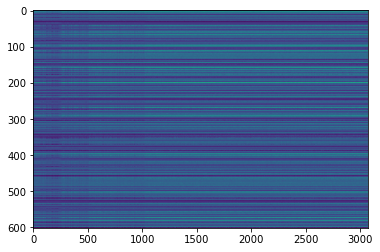

,AUC,pAUC
Source_0,0.635500,0.511053
Source_1,0.812800,0.560526
Source_2,0.741176,0.605029
Target_0,0.549700,0.516842
Target_1,0.603163,0.565628
Target_2,0.609862,0.544507
mean,0.658700,0.550598
h_mean,0.647256,0.548803


2021-05-24 00:17:31,937 - pytorch_modeler.py - INFO - epoch:14/300, train_losses:56.846572, val_AUC_hmean:0.647256, val_pAUC_hmean:0.548803, best_flag:True
2021-05-24 00:17:31,938 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.08it/s]
2021-05-24 00:17:32,400 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.29it/s]
2021-05-24 00:17:32,618 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.44it/s]
2021-05-24 00:17:32,835 - pytorch_modeler.py - INFO - epoch:15/300, train_losses:55.948240, val_AUC_hmean:0.629442, val_pAUC_hmean:0.529766, best_flag:False
2021-05-24 00:17:32,836 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.89it/s]
2021-05-24 00:17:33,320 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.03it/s]
2021-05-24 00:17:33,542 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.78it/s]
2021-05-24 00:17:33

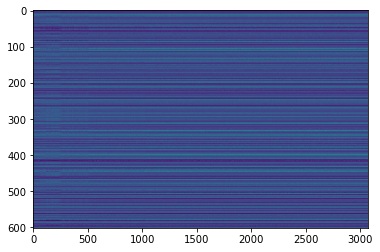

,AUC,pAUC
Source_0,0.668500,0.510526
Source_1,0.875800,0.645263
Source_2,0.752941,0.578291
Target_0,0.536500,0.517368
Target_1,0.592551,0.534264
Target_2,0.618224,0.553309
mean,0.674086,0.556504
h_mean,0.656821,0.553013


2021-05-24 00:17:36,363 - pytorch_modeler.py - INFO - epoch:18/300, train_losses:54.165047, val_AUC_hmean:0.656821, val_pAUC_hmean:0.553013, best_flag:True
2021-05-24 00:17:36,364 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.61it/s]
2021-05-24 00:17:36,835 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.22it/s]
2021-05-24 00:17:37,053 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.17it/s]


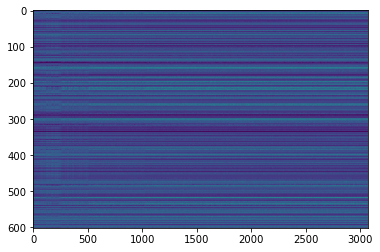

,AUC,pAUC
Source_0,0.699100,0.541579
Source_1,0.869900,0.631053
Source_2,0.765062,0.612534
Target_0,0.563000,0.508947
Target_1,0.613367,0.542965
Target_2,0.596117,0.509298
mean,0.684424,0.557729
h_mean,0.668813,0.553826


2021-05-24 00:17:38,078 - pytorch_modeler.py - INFO - epoch:19/300, train_losses:53.787829, val_AUC_hmean:0.668813, val_pAUC_hmean:0.553826, best_flag:True
2021-05-24 00:17:38,079 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.59it/s]
2021-05-24 00:17:38,550 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.18it/s]
2021-05-24 00:17:38,770 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.40it/s]


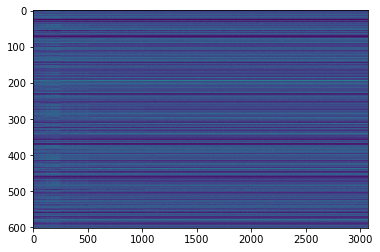

,AUC,pAUC
Source_0,0.712700,0.518421
Source_1,0.873100,0.634211
Source_2,0.771836,0.648654
Target_0,0.563000,0.524211
Target_1,0.620612,0.552954
Target_2,0.602557,0.534997
mean,0.690634,0.568908
h_mean,0.674826,0.564301


2021-05-24 00:17:39,759 - pytorch_modeler.py - INFO - epoch:20/300, train_losses:53.077695, val_AUC_hmean:0.674826, val_pAUC_hmean:0.564301, best_flag:True
2021-05-24 00:17:39,760 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.07it/s]
2021-05-24 00:17:40,241 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.81it/s]
2021-05-24 00:17:40,466 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.86it/s]
2021-05-24 00:17:40,692 - pytorch_modeler.py - INFO - epoch:21/300, train_losses:52.672138, val_AUC_hmean:0.667189, val_pAUC_hmean:0.562437, best_flag:False
2021-05-24 00:17:40,693 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.06it/s]
2021-05-24 00:17:41,156 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.11it/s]
2021-05-24 00:17:41,378 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.50it/s]
2021-05-24 00:17:41

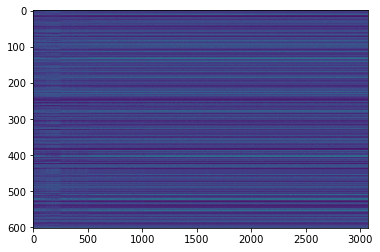

,AUC,pAUC
Source_0,0.721200,0.521579
Source_1,0.904100,0.681053
Source_2,0.802674,0.661788
Target_0,0.509900,0.512632
Target_1,0.533980,0.529753
Target_2,0.594195,0.545822
mean,0.677675,0.575438
h_mean,0.648275,0.567799


2021-05-24 00:17:43,326 - pytorch_modeler.py - INFO - epoch:23/300, train_losses:52.034873, val_AUC_hmean:0.648275, val_pAUC_hmean:0.567799, best_flag:True
2021-05-24 00:17:43,327 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 24.95it/s]
2021-05-24 00:17:43,810 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.40it/s]
2021-05-24 00:17:44,047 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.05it/s]
2021-05-24 00:17:44,271 - pytorch_modeler.py - INFO - epoch:24/300, train_losses:51.679817, val_AUC_hmean:0.660590, val_pAUC_hmean:0.565099, best_flag:False
2021-05-24 00:17:44,272 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.37it/s]
2021-05-24 00:17:44,729 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.93it/s]
2021-05-24 00:17:44,951 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.92it/s]


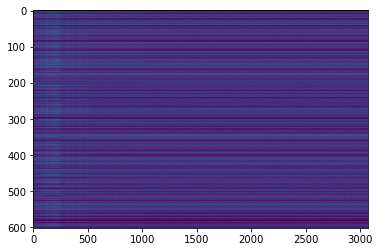

,AUC,pAUC
Source_0,0.721500,0.516316
Source_1,0.897700,0.690526
Source_2,0.786007,0.660850
Target_0,0.537300,0.514211
Target_1,0.558571,0.536520
Target_2,0.592368,0.543394
mean,0.682241,0.576969
h_mean,0.658488,0.568879


2021-05-24 00:17:45,974 - pytorch_modeler.py - INFO - epoch:25/300, train_losses:51.378941, val_AUC_hmean:0.658488, val_pAUC_hmean:0.568879, best_flag:True
2021-05-24 00:17:45,975 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.56it/s]
2021-05-24 00:17:46,429 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.23it/s]
2021-05-24 00:17:46,647 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.12it/s]


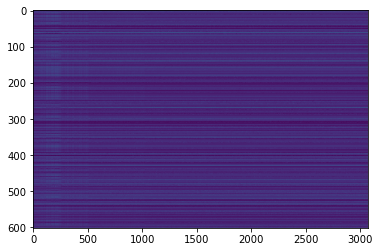

,AUC,pAUC
Source_0,0.730100,0.535263
Source_1,0.902300,0.708421
Source_2,0.783868,0.656159
Target_0,0.521200,0.525789
Target_1,0.566122,0.531579
Target_2,0.599385,0.555940
mean,0.683829,0.585525
h_mean,0.658826,0.577718


2021-05-24 00:17:47,629 - pytorch_modeler.py - INFO - epoch:26/300, train_losses:51.109072, val_AUC_hmean:0.658826, val_pAUC_hmean:0.577718, best_flag:True
2021-05-24 00:17:47,630 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.83it/s]
2021-05-24 00:17:48,097 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.31it/s]
2021-05-24 00:17:48,314 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.56it/s]
2021-05-24 00:17:48,528 - pytorch_modeler.py - INFO - epoch:27/300, train_losses:50.822458, val_AUC_hmean:0.679420, val_pAUC_hmean:0.571720, best_flag:False
2021-05-24 00:17:48,529 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.16it/s]
2021-05-24 00:17:49,008 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.27it/s]
2021-05-24 00:17:49,225 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.06it/s]
2021-05-24 00:17:49

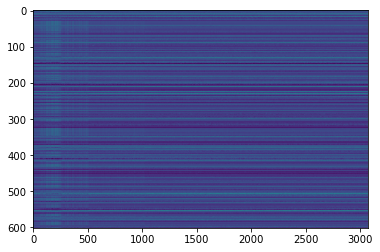

,AUC,pAUC
Source_0,0.722200,0.530526
Source_1,0.915900,0.726316
Source_2,0.776916,0.676330
Target_0,0.505600,0.518947
Target_1,0.580612,0.549409
Target_2,0.586505,0.540055
mean,0.681289,0.590264
h_mean,0.654393,0.580323


2021-05-24 00:17:51,157 - pytorch_modeler.py - INFO - epoch:29/300, train_losses:50.363848, val_AUC_hmean:0.654393, val_pAUC_hmean:0.580323, best_flag:True
2021-05-24 00:17:51,158 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.01it/s]
2021-05-24 00:17:51,621 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.03it/s]
2021-05-24 00:17:51,840 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.18it/s]
2021-05-24 00:17:52,063 - pytorch_modeler.py - INFO - epoch:30/300, train_losses:50.143672, val_AUC_hmean:0.655574, val_pAUC_hmean:0.565112, best_flag:False
2021-05-24 00:17:52,064 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.83it/s]
2021-05-24 00:17:52,531 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.71it/s]
2021-05-24 00:17:52,758 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.42it/s]


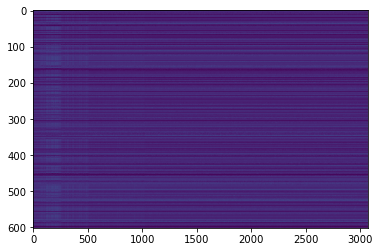

,AUC,pAUC
Source_0,0.731900,0.537368
Source_1,0.911700,0.706316
Source_2,0.798307,0.694624
Target_0,0.534700,0.530526
Target_1,0.600000,0.531794
Target_2,0.591503,0.538740
mean,0.694685,0.589895
h_mean,0.670894,0.580390


2021-05-24 00:17:53,809 - pytorch_modeler.py - INFO - epoch:31/300, train_losses:49.891052, val_AUC_hmean:0.670894, val_pAUC_hmean:0.580390, best_flag:True
2021-05-24 00:17:53,810 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.80it/s]
2021-05-24 00:17:54,277 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.42it/s]
2021-05-24 00:17:54,492 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.14it/s]
2021-05-24 00:17:54,713 - pytorch_modeler.py - INFO - epoch:32/300, train_losses:49.709118, val_AUC_hmean:0.661883, val_pAUC_hmean:0.578483, best_flag:False
2021-05-24 00:17:54,714 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.86it/s]
2021-05-24 00:17:55,182 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.05it/s]
2021-05-24 00:17:55,402 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.08it/s]


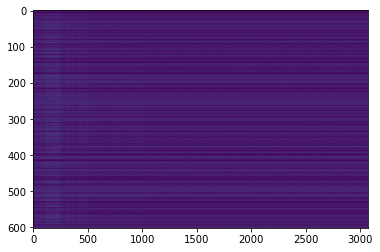

,AUC,pAUC
Source_0,0.748100,0.548947
Source_1,0.916100,0.741053
Source_2,0.796970,0.686650
Target_0,0.506800,0.516842
Target_1,0.541429,0.534264
Target_2,0.592561,0.543091
mean,0.683660,0.595141
h_mean,0.652828,0.583923


2021-05-24 00:17:56,393 - pytorch_modeler.py - INFO - epoch:33/300, train_losses:49.589643, val_AUC_hmean:0.652828, val_pAUC_hmean:0.583923, best_flag:True
2021-05-24 00:17:56,394 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.81it/s]
2021-05-24 00:17:56,861 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.89it/s]
2021-05-24 00:17:57,084 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.26it/s]
2021-05-24 00:17:57,305 - pytorch_modeler.py - INFO - epoch:34/300, train_losses:49.307042, val_AUC_hmean:0.656272, val_pAUC_hmean:0.580198, best_flag:False
2021-05-24 00:17:57,306 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.96it/s]
2021-05-24 00:17:57,771 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.23it/s]
2021-05-24 00:17:57,988 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.26it/s]
2021-05-24 00:17:58

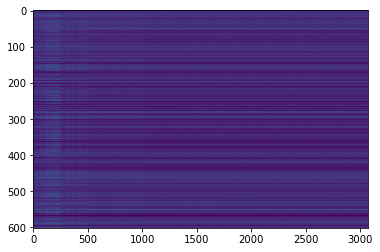

,AUC,pAUC
Source_0,0.763100,0.548947
Source_1,0.919900,0.719474
Source_2,0.804545,0.689933
Target_0,0.516300,0.515263
Target_1,0.611122,0.549517
Target_2,0.583910,0.548655
mean,0.699813,0.595298
h_mean,0.672175,0.585699


2021-05-24 00:18:00,892 - pytorch_modeler.py - INFO - epoch:37/300, train_losses:48.858292, val_AUC_hmean:0.672175, val_pAUC_hmean:0.585699, best_flag:True
2021-05-24 00:18:00,892 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.42it/s]
2021-05-24 00:18:01,367 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00,  9.64it/s]
2021-05-24 00:18:01,596 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00,  9.76it/s]
2021-05-24 00:18:01,826 - pytorch_modeler.py - INFO - epoch:38/300, train_losses:48.691318, val_AUC_hmean:0.664009, val_pAUC_hmean:0.572365, best_flag:False
2021-05-24 00:18:01,827 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.46it/s]
2021-05-24 00:18:02,301 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.00it/s]
2021-05-24 00:18:02,521 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.34it/s]
2021-05-24 00:18:02

100%|██████████| 2/2 [00:00<00:00,  9.79it/s]
2021-05-24 00:18:16,495 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.29it/s]
2021-05-24 00:18:16,715 - pytorch_modeler.py - INFO - epoch:54/300, train_losses:46.340876, val_AUC_hmean:0.646448, val_pAUC_hmean:0.565251, best_flag:False
2021-05-24 00:18:16,716 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 26.00it/s]
2021-05-24 00:18:17,180 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 10.11it/s]
2021-05-24 00:18:17,401 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 10.02it/s]
2021-05-24 00:18:17,624 - pytorch_modeler.py - INFO - epoch:55/300, train_losses:46.171586, val_AUC_hmean:0.663113, val_pAUC_hmean:0.580603, best_flag:False
2021-05-24 00:18:17,626 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 25.86it/s]
2021-05-24 00:18:18,092 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2

In [ ]:
run(machine_types[6])